In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import sys
sys.path.insert(0, './libraries')
from DataGenerator import DataGenerator
import tensorflow as tf
from Speckle2Void import Speckle2V

from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

%reload_ext autoreload
%autoreload 2

/home/carldelrieu/Bureau/Etudes/Master/M2-IAFA-2/TSAI/Projet/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/carldelrieu/Bureau/Etudes/Master/M2-IAFA-2/TSAI/Projet/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/carldelrieu/Bureau/Etudes/Master/M2-IAFA-2/TSAI/Projet/.venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [3]:
tf.reset_default_graph()
batch_size=16

dir_train = "../DataSet_SAR/TerraSAR_X/HDF5_SLC_DECORRELATED_2/"
dir_test = "../DataSet_SAR/TerraSAR_X/HDF5_SLC_TEST_DECORRELATED_2/"

file_checkpoint = 's2v_checkpoint/model.ckpt-299999'#None for the latest checkpoint

model = Speckle2V(dir_train,
                  dir_test,
                  file_checkpoint,
                  batch_size=batch_size,
                  patch_size=64,
                  model_name='speckle2void',
                  lr=1e-04, 
                  steps_per_epoch=2000,
                  k_penalty_tv=5e-05,
                  shift_list=[3,1],
                  prob = [0.9,0.1],
                  clip=500000,
                  norm=100000,
                  L_noise=1)    

2025-01-14 19:16:42.930658: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Could not dlopen library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-14 19:16:42.930679: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-14 19:16:42.930706: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Latitude-7490): /proc/driver/nvidia/version does not exist
2025-01-14 19:16:42.931093: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-01-14 19:16:42.937258: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1899950000 Hz
2025-01-14 19:16:42.937634: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2a1f2f00 executing computations on platform Host. Devices:
2025-01-14 19:16:

In [4]:
model.build_inference()
model.load_weights()



Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).

Taking the specified checkpoint...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from s2v_checkpoint/model.ckpt-299999


2025-01-14 19:16:47.158079: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


In [5]:
dir_test = "./test_examples/"
datagen = DataGenerator()
imgs = datagen.load_imgs_from_directory(directory = dir_test,filter='decorr*.mat',max_files=None)

Reading ./test_examples/decorr_complex_tsx_SLC_0.mat...


In [6]:
imgs = [img[:,0:1000,0:1000,:] for img in imgs]

In [7]:
cleaned_img = model.predict(imgs[0])


2025-01-14 19:17:34.269812: W tensorflow/core/framework/allocator.cc:107] Allocation of 1024000000 exceeds 10% of system memory.


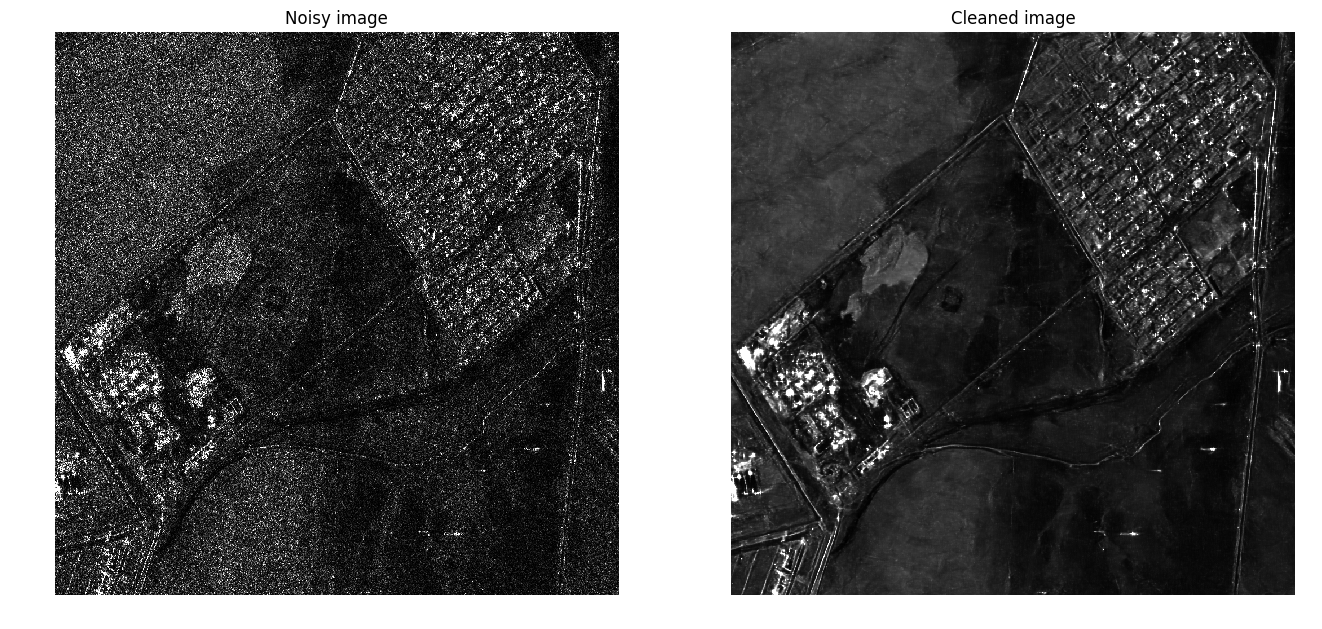

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].imshow(imgs[0][0,:,:,0], cmap='gray', interpolation = 'none', vmax=50000)
ax[0].set_title('Noisy image')
ax[0].axis('off')

ax[1].imshow(cleaned_img[0,:,:,0], cmap='gray', interpolation = 'none', vmax=50000)
ax[1].set_title('Cleaned image')
ax[1].axis('off')

plt.show()

In [9]:
import numpy as np

def print_metrics(gt_imgs, cleaned_imgs):
    mse = np.mean((gt_imgs - cleaned_imgs) ** 2)
    psnr = 10 * np.log10((np.max(gt_imgs) ** 2) / mse)
    print(f'MSE: {mse}')
    print(f'PSNR: {psnr}')

print_metrics(imgs[0], cleaned_img)

MSE: 181793280.0
PSNR: 74.09864646012872


In [10]:
plt.imsave('res/test1',cleaned_img[0,:,:,0] , cmap='gray', vmin=0,vmax=50000)

# Nos tests

In [11]:
from scipy.ndimage import zoom

In [12]:
def create_dataset(path, height = 1000, width = 1000):
    imgs = np.zeros((8, 1, height, width, 1))
    gt_imgs = np.zeros((8, 1, height, width, 1))

    for i in range(4):
        tmp_img = datagen.load_imgs_from_directory(directory = f'{path}/{i + 1}', filter='bmode.png', max_files=None)
        tmp_gt_img = datagen.load_imgs_from_directory(directory = f'{path}/{i + 1}', filter='bmode_GT.png', max_files=None)
        
        tmp_img = np.array(tmp_img)
        tmp_gt_img = np.array(tmp_gt_img)
        
        tmp_img = zoom(tmp_img, (1, 1, height / tmp_img.shape[2], width / tmp_img.shape[3], 1))
        tmp_gt_img = zoom(tmp_gt_img, (1, 1, height / tmp_gt_img.shape[2], width / tmp_gt_img.shape[3], 1))

        imgs[i] = tmp_img
        gt_imgs[i] = tmp_gt_img
    
    for i in range(4, 8):
        tmp_img = datagen.load_imgs_from_directory(directory = f'{path}/{i - 3}', filter='rf.png', max_files=None)
        tmp_gt_img = datagen.load_imgs_from_directory(directory = f'{path}/{i - 3}', filter='GT_rf.png', max_files=None)
        
        tmp_img = np.array(tmp_img)
        tmp_gt_img = np.array(tmp_gt_img)
        
        tmp_img = zoom(tmp_img, (1, 1, height / tmp_img.shape[2], width / tmp_img.shape[3], 1))
        tmp_gt_img = zoom(tmp_gt_img, (1, 1, height / tmp_gt_img.shape[2], width / tmp_gt_img.shape[3], 1))

        imgs[i] = tmp_img
        gt_imgs[i] = tmp_gt_img

    return imgs, gt_imgs


In [13]:
irit_imgs, gt_imgs = create_dataset('US_data/simu')

Reading US_data/simu/1/bmode.png...
Reading US_data/simu/1/bmode_GT.png...
Reading US_data/simu/2/bmode.png...
Reading US_data/simu/2/bmode_GT.png...
Reading US_data/simu/3/bmode.png...
Reading US_data/simu/3/bmode_GT.png...
Reading US_data/simu/4/bmode.png...
Reading US_data/simu/4/bmode_GT.png...
Reading US_data/simu/1/rf.png...
Reading US_data/simu/1/GT_rf.png...
Reading US_data/simu/2/rf.png...
Reading US_data/simu/2/GT_rf.png...
Reading US_data/simu/3/rf.png...
Reading US_data/simu/3/GT_rf.png...
Reading US_data/simu/4/rf.png...
Reading US_data/simu/4/GT_rf.png...


In [14]:
print(irit_imgs.shape, gt_imgs.shape)

(8, 1, 1000, 1000, 1) (8, 1, 1000, 1000, 1)


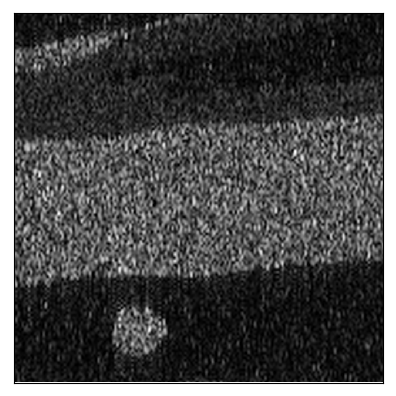

In [15]:
plt.imshow(gt_imgs[0, 0, :, :, 0], cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


In [16]:
def add_multiplicative_speckle_noise(imgs, L_noise):
    gamma_noise = np.random.gamma(L_noise, 1 / L_noise, imgs.shape)
    return imgs * gamma_noise

noisy_gt_imgs = add_multiplicative_speckle_noise(gt_imgs, 1)

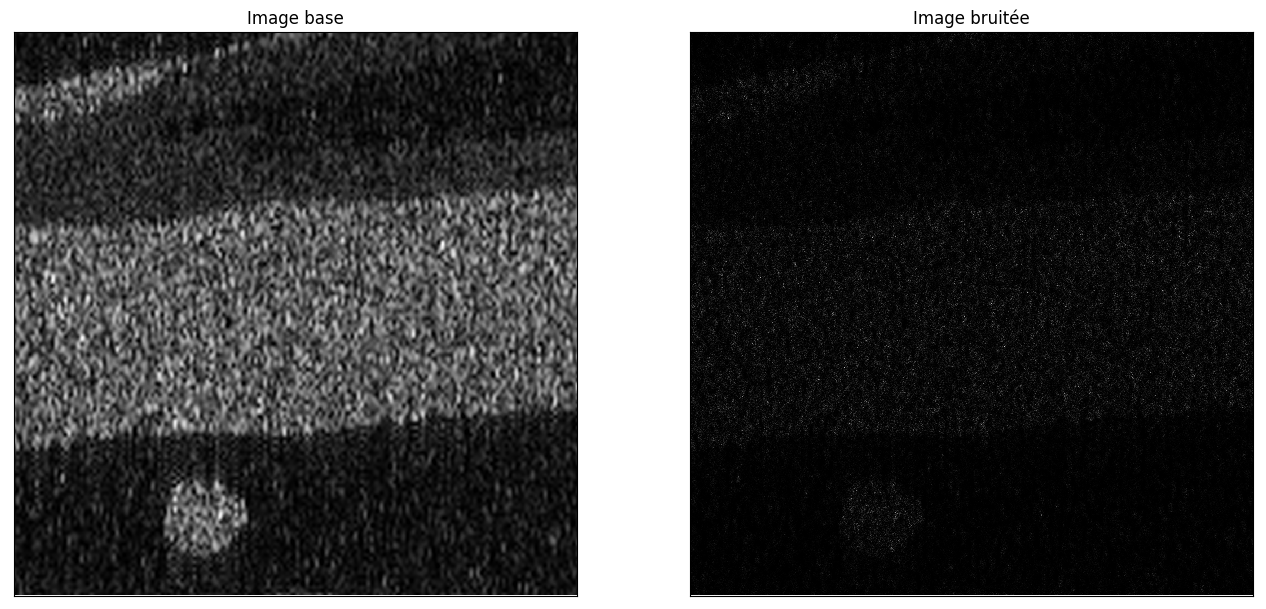

In [17]:
plt.figure(figsize=[16,8])
plt.subplot(1, 2, 1)
plt.imshow(gt_imgs[0, 0, :, :, 0], cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Image base')
plt.subplot(1, 2, 2)
plt.imshow(noisy_gt_imgs[0, 0, :, :, 0], cmap = 'gray')
plt.xticks([]), plt.yticks([])
plt.title('Image bruitée')
plt.show()

1 / 4
2 / 4
3 / 4
4 / 4
Image 1
MSE: 1127.231688
PSNR: 17.84589393764142
Image 2
MSE: 1127.862407
PSNR: 17.77690574597011
Image 3
MSE: 1513.057373
PSNR: 16.433840157572725
Image 4
MSE: 1525.076991
PSNR: 16.399476430486118


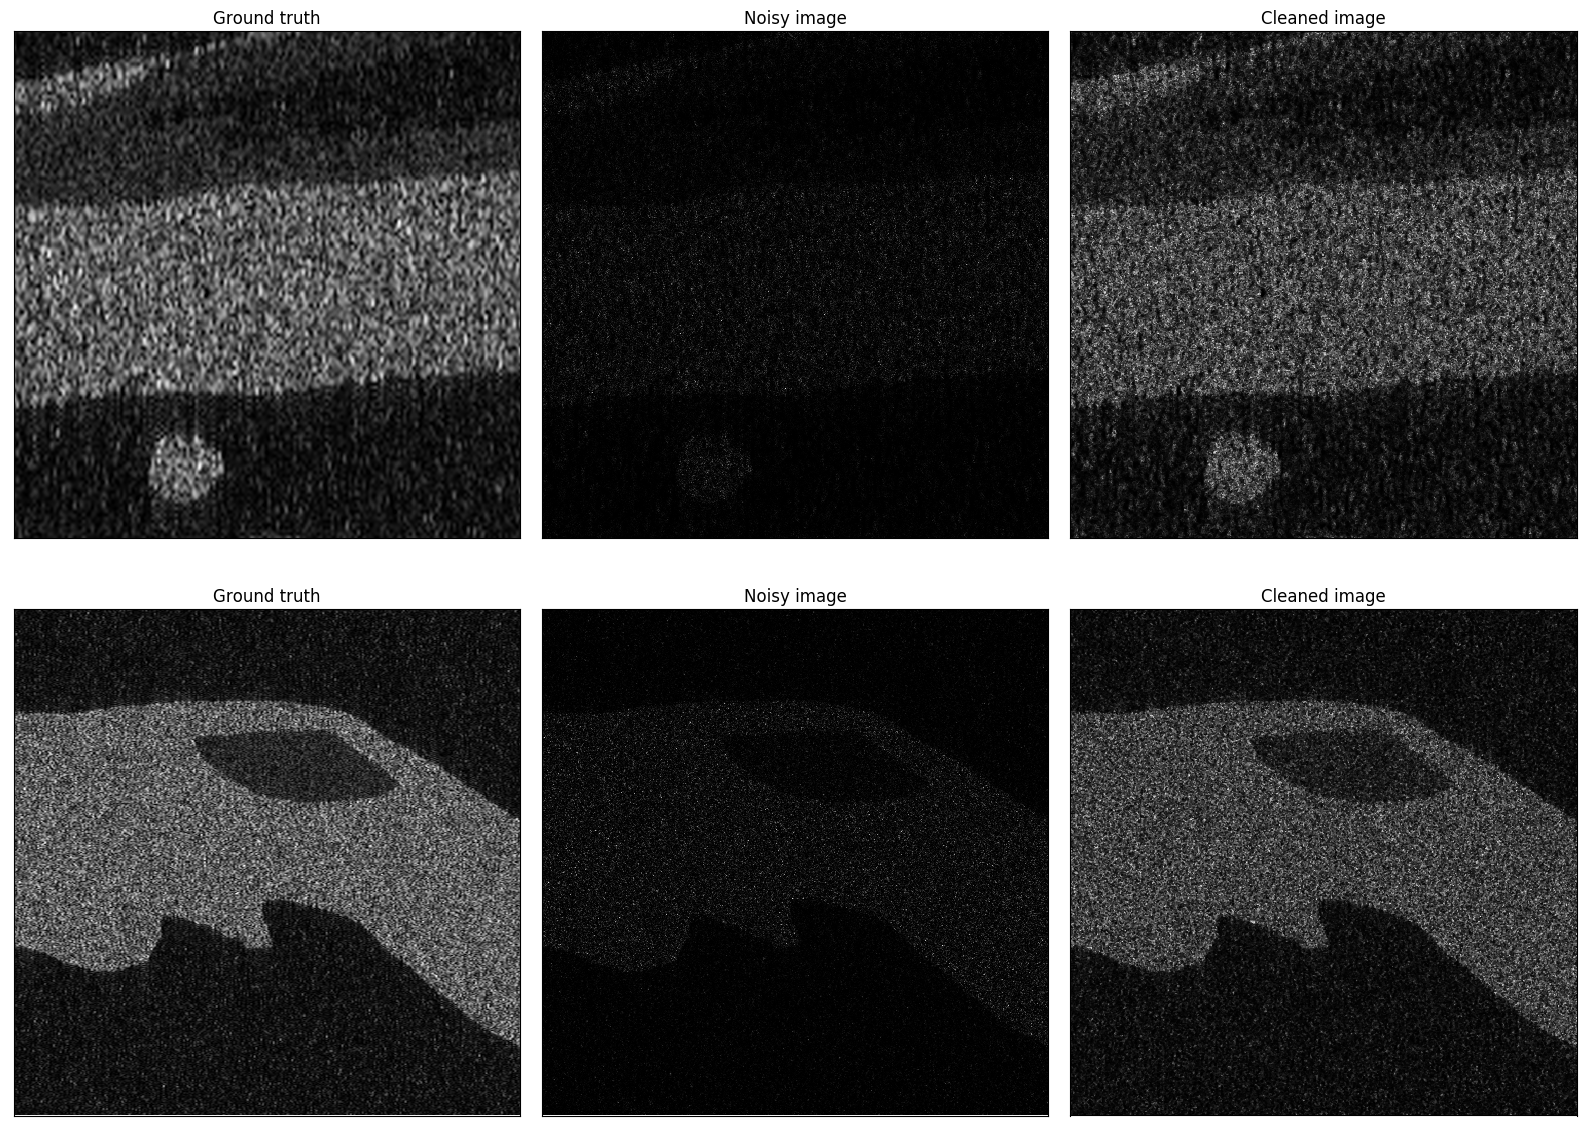

In [18]:
import cv2

def classic_denoising(img):
    return cv2.medianBlur(img.astype(np.uint8), 3)

classic_cleaned_imgs = np.zeros((noisy_gt_imgs.shape))

for i in range(4):
    print(f'{i + 1} / {4}')
    denoised_img = classic_denoising(noisy_gt_imgs[i][0][:, :, 0])
    classic_cleaned_imgs[i, 0, :, :, 0] = denoised_img

for i in range(4):
    print(f'Image {i + 1}')
    print_metrics(gt_imgs[i], classic_cleaned_imgs[i])


plt.figure(figsize=(16, 12))

for i in range(2):
    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(gt_imgs[i][0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Ground truth')

    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(noisy_gt_imgs[i][0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')

    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(classic_cleaned_imgs[i][0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Cleaned image')

plt.tight_layout()
plt.show()

In [19]:
cleaned_imgs = np.zeros((noisy_gt_imgs.shape))

for i in range(4):
    print(f'{i + 1} / {4}')
    cleaned_imgs[i] = model.predict(noisy_gt_imgs[i])

1 / 4


2025-01-14 19:21:20.044740: W tensorflow/core/framework/allocator.cc:107] Allocation of 1024000000 exceeds 10% of system memory.


2 / 4


2025-01-14 19:21:56.979937: W tensorflow/core/framework/allocator.cc:107] Allocation of 1024000000 exceeds 10% of system memory.


3 / 4


2025-01-14 19:22:34.791773: W tensorflow/core/framework/allocator.cc:107] Allocation of 1024000000 exceeds 10% of system memory.


4 / 4


2025-01-14 19:23:12.069366: W tensorflow/core/framework/allocator.cc:107] Allocation of 1024000000 exceeds 10% of system memory.


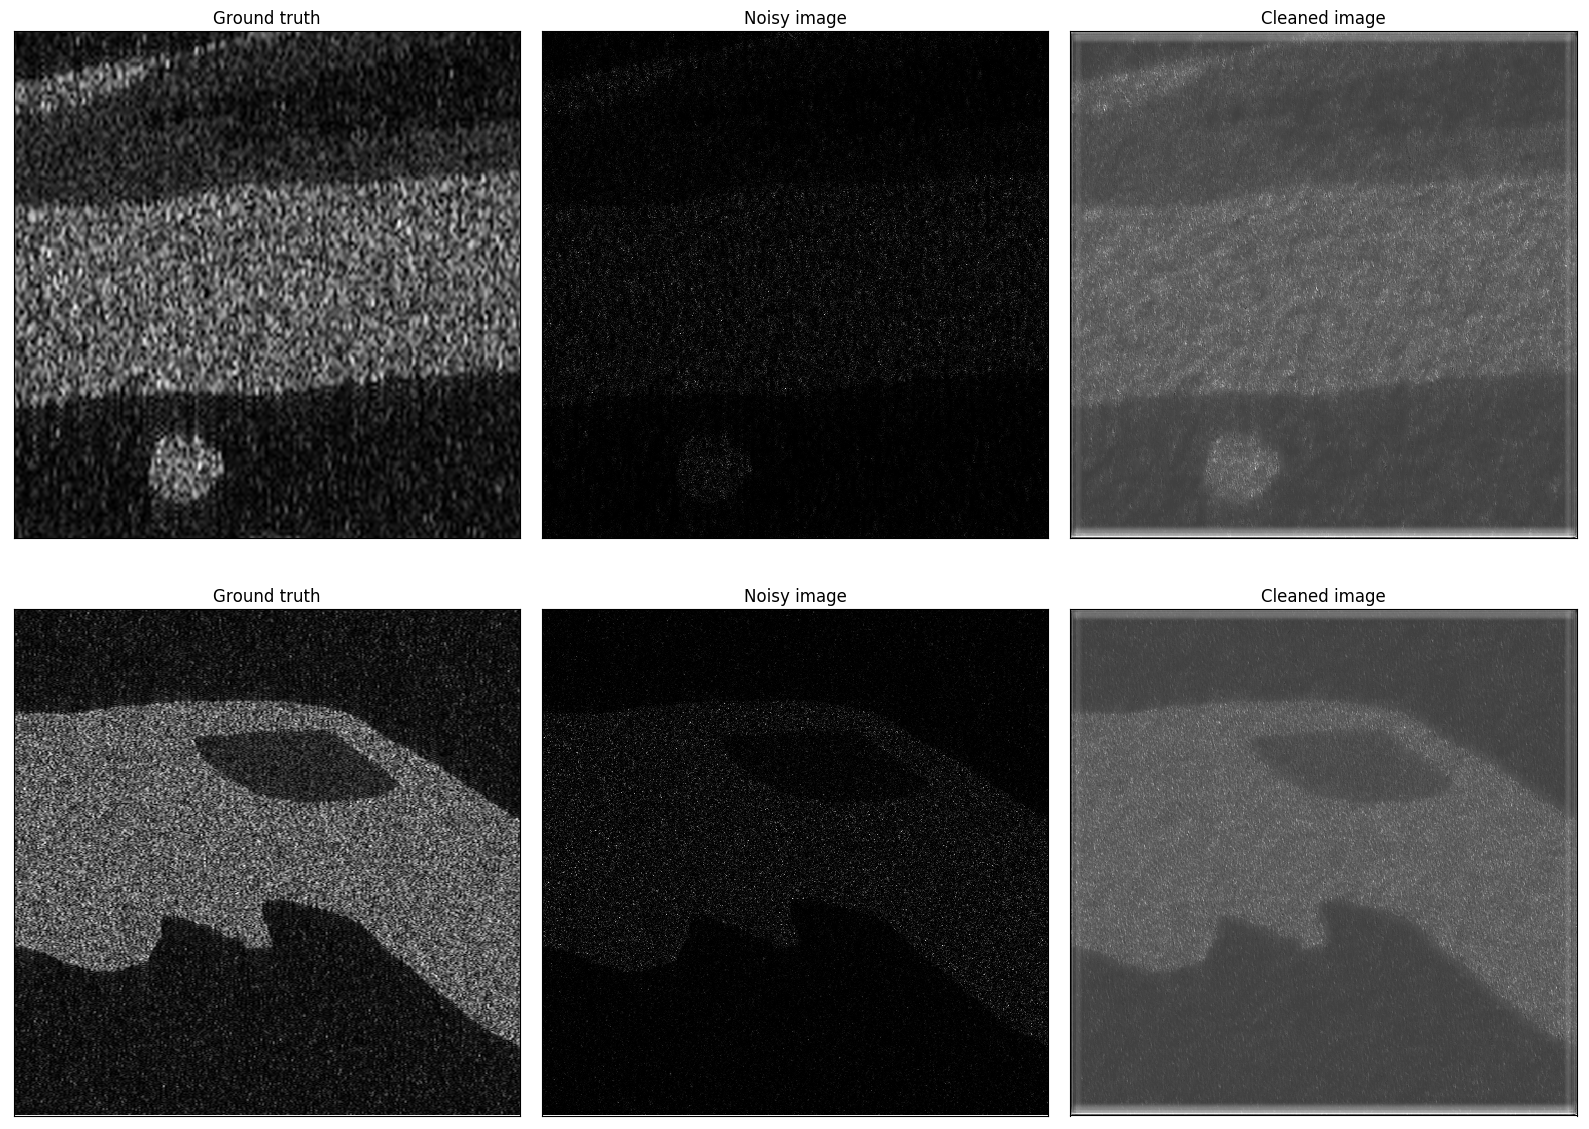

In [20]:
plt.figure(figsize=(16, 12))

for i in range(2):

    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(gt_imgs[i][0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Ground truth')

    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(noisy_gt_imgs[i][0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Noisy image')

    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(cleaned_imgs[i][0, :, :, 0], cmap='gray')
    plt.xticks([]), plt.yticks([])
    plt.title('Cleaned image')

plt.tight_layout()
plt.show()

In [21]:
for i in range(4):
    print(f'Image {i + 1}')
    print_metrics(gt_imgs[i], cleaned_imgs[i])


Image 1
MSE: 327932.2591307696
PSNR: -6.791815582548586
Image 2
MSE: 328531.9739984621
PSNR: -6.866309472246313
Image 3
MSE: 324070.6433752564
PSNR: -6.874002794032423
Image 4
MSE: 323847.3637613565
PSNR: -6.871009541583542
